In [450]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

In [451]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [452]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

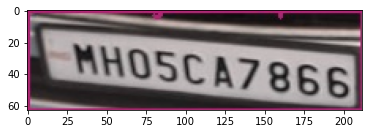

In [673]:
plate_image = cv2.imread('plate_output1/21.JPEG')
img = plate_image
plt.imshow(plate_image)
plt.plot

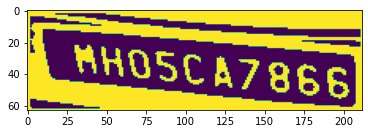

In [674]:

imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

height = img.shape[0]
width = img.shape[1]
area = height * width

scale1 = 0.001
scale2 = 0.1
area_condition1 = area * scale1
area_condition2 = area * scale2
# global thresholding
ret1,th1 = cv2.threshold(imgray,150,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(imgray,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(th2)
plt.plot

kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
thre_mor = cv2.morphologyEx(th2, cv2.MORPH_DILATE, kernel3)




In [675]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts


63 212
8 46
9 47
10 5
8 5
51 200
17 195
18 14
19 14
18 14
16 10
19 14
19 13
20 11
6 6
19 13
19 13
8 8
7 8
20 14
6 39
7 9
20 14
8 9
Detect 10 letters...


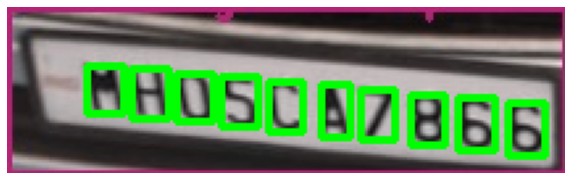

In [677]:
contours, hierarchy = cv2.findContours(th2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # sort contours
cont = sorted(contours, key=cv2.contourArea, reverse=True)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    print(h,w)
    ratio = h/w
    if 1<=ratio<=4.0: # Only select contour with defined ratio
        if 0.9>=h/plate_image.shape[0]>=0.27: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)
            w=w+2
            # Sperate number and gibe prediction
            curr_num = th2[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)


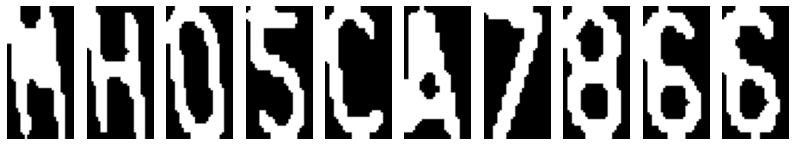

In [678]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)  

In [679]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [680]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

MH05CA7866


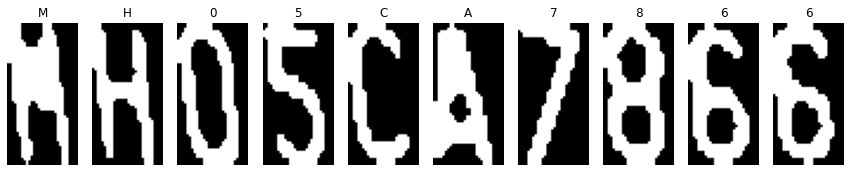

In [681]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)
#plt.savefig('final_result.png', dpi=300)